## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [17]:
%load_ext autoreload
%autoreload 2

import IPython
import sys
import os
import random
import time
from dataclasses import dataclass
from enum import Enum

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch import optim
from torchvision import transforms
from torchinfo import summary

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import h5py
import tifffile
import tqdm




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <font style="color:lightblue">Functions</font>

In [2]:


def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)


def plotData(dataY, rangeY=None, dataYR=None, rangeYR=None,
             dataX=None, rangeX=None, rangeP=None,
             figsize=(16,8), saveTo=None, show=True):

    if type(dataY) is np.ndarray :
        plotData((dataY,), rangeY=rangeY, dataYR=dataYR, rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataYR) is np.ndarray :
        plotData(dataY, rangeY=rangeY, dataYR=(dataYR,), rangeYR=rangeYR,
             dataX=dataX, rangeX=rangeX, rangeP=rangeP,
             figsize=figsize, saveTo=saveTo, show=show)
        return
    if type(dataY) is not tuple :
        eprint(f"Unknown data type to plot: {type(dataY)}.")
        return
    if type(dataYR) is not tuple and dataYR is not None:
        eprint(f"Unknown data type to plot: {type(dataYR)}.")
        return

    last = min( len(data) for data in dataY )
    if dataYR is not None:
        last = min( last,  min( len(data) for data in dataYR ) )
    if dataX is not None:
        last = min(last, len(dataX))
    if rangeP is None :
        rangeP = (0,last)
    elif type(rangeP) is int :
        rangeP = (0,rangeP) if rangeP > 0 else (-rangeP,last)
    elif type(rangeP) is tuple :
        rangeP = ( 0    if rangeP[0] is None else rangeP[0],
                   last if rangeP[1] is None else rangeP[1],)
    else :
        eprint(f"Bad data type on plotData input rangeP: {type(rangeP)}")
        raise Exception(f"Bug in the code.")
    rangeP = np.s_[ max(0, rangeP[0]) : min(last, rangeP[1]) ]
    if dataX is None :
        dataX = np.arange(rangeP.start, rangeP.stop)

    plt.style.use('default')
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.xaxis.grid(True, 'both', linestyle='dotted')
    if rangeX is not None :
        ax1.set_xlim(rangeX)
    else :
        ax1.set_xlim(rangeP.start,rangeP.stop-1)

    ax1.yaxis.grid(True, 'both', linestyle='dotted')
    nofPlots = len(dataY)
    if rangeY is not None:
        ax1.set_ylim(rangeY)
    colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
    for idx , data in enumerate(dataY):
        ax1.plot(dataX, data[rangeP], linestyle='-',  color=colors[idx])

    if dataYR is not None : # right Y axis
        ax2 = ax1.twinx()
        ax2.yaxis.grid(True, 'both', linestyle='dotted')
        nofPlots = len(dataYR)
        if rangeYR is not None:
            ax2.set_ylim(rangeYR)
        colors = [ matplotlib.colors.hsv_to_rgb((hv/nofPlots, 1, 1)) for hv in range(nofPlots) ]
        for idx , data in enumerate(dataYR):
            ax2.plot(dataX, data[rangeP], linestyle='dashed',  color=colors[idx])

    if saveTo:
        fig.savefig(saveTo)
    if not show:
        plt.close(fig)


def plotImage(image) :
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    plt.show()


def plotImages(images) :
    for i, img in enumerate(images) :
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()


def sliceShape(shape, sl) :
    if type(shape) is int :
        shape = torch.Size([shape])
    if type(sl) is tuple :
        if len(shape) != len(sl) :
            raise Exception(f"Different sizes of shape {shape} and sl {sl}")
        out = []
        for i in range(0, len(shape)) :
            indeces = sl[i].indices(shape[i])
            out.append(indeces[1]-indeces[0])
        return out
    elif type(sl) is slice :
        indeces = sl.indices(shape[0])
        return indeces[1]-indeces[0]
    else :
        raise Exception(f"Incompatible object {sl}")


def tensorStat(stat) :
    print(stat.mean().item(), stat.std().item(), (stat.std()/stat.mean()).item(), stat.min().item(), stat.max().item())


def fillWheights(seq) :
    for wh in seq :
        if hasattr(wh, 'weight') :
            torch.nn.init.xavier_uniform_(wh.weight)


def unsqeeze4dim(tens):
    orgDims = tens.dim()
    if tens.dim() == 2 :
        tens = tens.unsqueeze(0)
    if tens.dim() == 3 :
        tens = tens.unsqueeze(1)
    return tens, orgDims


def squeezeOrg(tens, orgDims):
    if orgDims == tens.dim():
        return tens
    if tens.dim() != 4 or orgDims > 4 or orgDims < 2:
        raise Exception(f"Unexpected dimensions to squeeze: {tens.dim()} {orgDims}.")
    if orgDims < 4 :
        if tens.shape[1] > 1:
            raise Exception(f"Cant squeeze dimension 1 in: {tens.shape}.")
        tens = tens.squeeze(1)
    if orgDims < 3 :
        if tens.shape[0] > 1:
            raise Exception(f"Cant squeeze dimension 0 in: {tens.shape}.")
        tens = tens.squeeze(0)
    return tens


### <font style="color:lightblue">Configs</font>

In [3]:
def set_seed(SEED_VALUE):
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    np.random.seed(SEED_VALUE)

seed = 7
set_seed(seed)

@dataclass(frozen=True)
class TCfg:
    exec = 1
    device: torch.device = f"cuda:{exec}"
    nofEpochs: int = 2048
    latentDim: int = 64
    batchSize: int = 65536
    labelSmoothFac: float = 1.0 # For Real labels (or set to 1.0 for no smoothing).
    learningRateD: float = 0.00002
    learningRateG: float = 0.00002
    historyHDF = f"train_{exec}.hdf"

class DCfg:
    gapW = 2
    sinoSh = (5*gapW,5*gapW) # 10,10
    readSh = (8*sinoSh[0], 8*sinoSh[0]) # 80,80
    sinoSize = math.prod(sinoSh)
    gapSh = (sinoSh[0],gapW)
    gapSize = math.prod(gapSh)
    gapRngX = np.s_[ sinoSh[1]//2 - gapW//2 : sinoSh[1]//2 + gapW//2 ]
    gapRng = np.s_[ : , gapRngX ]
    disRng = np.s_[ gapW:-gapW , gapRngX ]




### <font style="color:lightblue">Save/Load model</font>

In [4]:
def save_model(model, device, model_path):
    if not device == 'cpu':
        model.to('cpu')
    torch.save(model.state_dict(), model_path)
    if not device == 'cpu':
        model.to(device)
    return

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    return model


def addToHDF(filename, containername, data) :
    if len(data.shape) == 2 :
        data=np.expand_dims(data, 0)
    if len(data.shape) != 3 :
        raise Exception(f"Not appropriate input array size {data.shape}.")

    with h5py.File(filename,'a') as file :

        if  containername not in file.keys():
            dset = file.create_dataset(containername, data.shape,
                                       maxshape=(None,data.shape[1],data.shape[2]),
                                       dtype='f')
            dset[()] = data
            return

        dset = file[containername]
        csh = dset.shape
        if csh[1] != data.shape[1] or csh[2] != data.shape[2] :
            raise Exception(f"Shape mismatch: input {data.shape}, file {dset.shape}.")
        msh = dset.maxshape
        newLen = csh[0] + data.shape[0]
        if msh[0] is None or msh[0] >= newLen :
            dset.resize(newLen, axis=0)
        else :
            raise Exception(f"Insufficient maximum shape {msh} to add data"
                            f" {data.shape} to current volume {dset.shape}.")
        dset[csh[0]:newLen,...] = data
        file.close()


    return 0

## <font style="color:lightblue">Data</font>

### <font style="color:lightblue">Raw Read</font>

In [5]:

class StripesFromHDF :

    def __init__(self, sampleName, maskName, bgName=None, dfName=None, loadToMem=True):

        sampleHDF = sampleName.split(':')
        if len(sampleHDF) != 2 :
            raise Exception(f"String \"{sampleName}\" does not represent an HDF5 format.")
        with h5py.File(sampleHDF[0],'r') as trgH5F:
            if  sampleHDF[1] not in trgH5F.keys():
                raise Exception(f"No dataset '{sampleHDF[1]}' in input file {sampleHDF[0]}.")
            self.data = trgH5F[sampleHDF[1]]
            if not self.data.size :
                raise Exception(f"Container \"{sampleName}\" is zero size.")
            self.sh = self.data.shape
            if len(self.sh) != 3 :
                raise Exception(f"Dimensions of the container \"{sampleName}\" is not 3 {self.sh}.")
            self.fsh = self.sh[1:3]
            self.volume = None
            if loadToMem :
                self.volume = np.empty(self.sh, dtype=np.float32)
                self.data.read_direct(self.volume)
                trgH5F.close()

            def loadImage(imageName) :
                if not imageName:
                    return None
                imdata = imread(imageName).astype(np.float32)
                if len(imdata.shape) == 3 :
                    imdata = np.mean(imdata[:,:,0:3], 2)
                if imdata.shape != self.fsh :
                    raise Exception(f"Dimensions of the input image \"{imageName}\" {imdata.shape} "
                                    f"do not match the face of the container \"{sampleName}\" {self.fsh}.")
                return imdata

            self.mask = loadImage(maskName)
            if self.mask is None :
                self.mask = np.ones(self.fsh, dtype=np.uint8)
            self.mask = self.mask.astype(bool)
            self.bg = loadImage(bgName)
            self.df = loadImage(dfName)
            if self.bg is not None :
                if self.df is not None:
                    self.bg -= self.df
                self.mask  &=  self.bg > 0.0

            self.allIndices = []
            for yCr in range(0,self.fsh[0]) :
                for xCr in range(0,self.fsh[1]) :
                    idx = np.s_[yCr,xCr]
                    if self.mask[idx] :
                        if self.volume is not None :
                            if self.df is not None :
                                self.volume[:,*idx] -= self.df[idx]
                            if self.bg is not None :
                                self.volume[:,*idx] /= self.bg[idx]
                        if  xCr + DCfg.readSh[1] < self.fsh[1] \
                        and np.all( self.mask[yCr,xCr+1:xCr+DCfg.readSh[1]] ) :
                            self.allIndices.append(idx)

    def get_dataset(self, transform=None) :

        class Sinos(torch.utils.data.Dataset) :

            def __init__(self, root, transform=None):
                self.container = root
                self.transform = transforms.Compose([transforms.ToTensor(), transform]) \
                    if transform else transforms.ToTensor()

            def __len__(self):
                return len(self.container.allIndices)

            def __getitem__(self, index, idxs=None):
                idx = self.container.allIndices[index]
                if idxs is None :
                    idxs = random.randint(0,self.container.sh[0]-DCfg.readSh[0]-1)
                xyrng=np.s_[ idx[0], idx[1]:idx[1]+DCfg.readSh[1] ]
                if self.container.volume is not None :
                    data = self.container.volume[idxs:idxs+DCfg.readSh[0], *xyrng]
                else :
                    data = self.container.data[idxs:idxs+DCfg.readSh[0], *xyrng]
                    if self.container.df is not None :
                        data -= self.container.df[None,*xyrng]
                    if self.container.bg is not None :
                        data /= self.container.bg[None,*xyrng]
                if self.transform :
                    data = self.transform(data)
                return data

        return Sinos(self, transform)

#sinoRoot = StripesFromHDF("/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/SAMPLE_Y0_BG.hdf:/data",
#                          "/mnt/ssdData/4176862R_Eig_Threshold-4keV/output/maskc.tif",
#                          None, None) # 229247,541 @ gap2

sinoRoot = StripesFromHDF("/mnt/hddData/Linda_18515/output/Lamb1_Eiger_7m_45keV_360Scan/for_sinogap.hdf:/data",
                          "/mnt/hddData/Linda_18515/output/Lamb1_Eiger_7m_45keV_360Scan/for_sinogap_mask.tif",
                          None, None )  # 34008,1620 @ gap2


### <font style="color:lightblue">Transform</font>

In [6]:
dataTransform =  transforms.Compose([
    transforms.Resize(DCfg.sinoSh),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=(0.5), std=(1))
])
trainSet = sinoRoot.get_dataset(dataTransform)

### <font style="color:lightblue">Show</font>

-0.048245951533317566 0.09211321175098419 -1.9092422723770142 -0.2303464114665985 0.10024410486221313


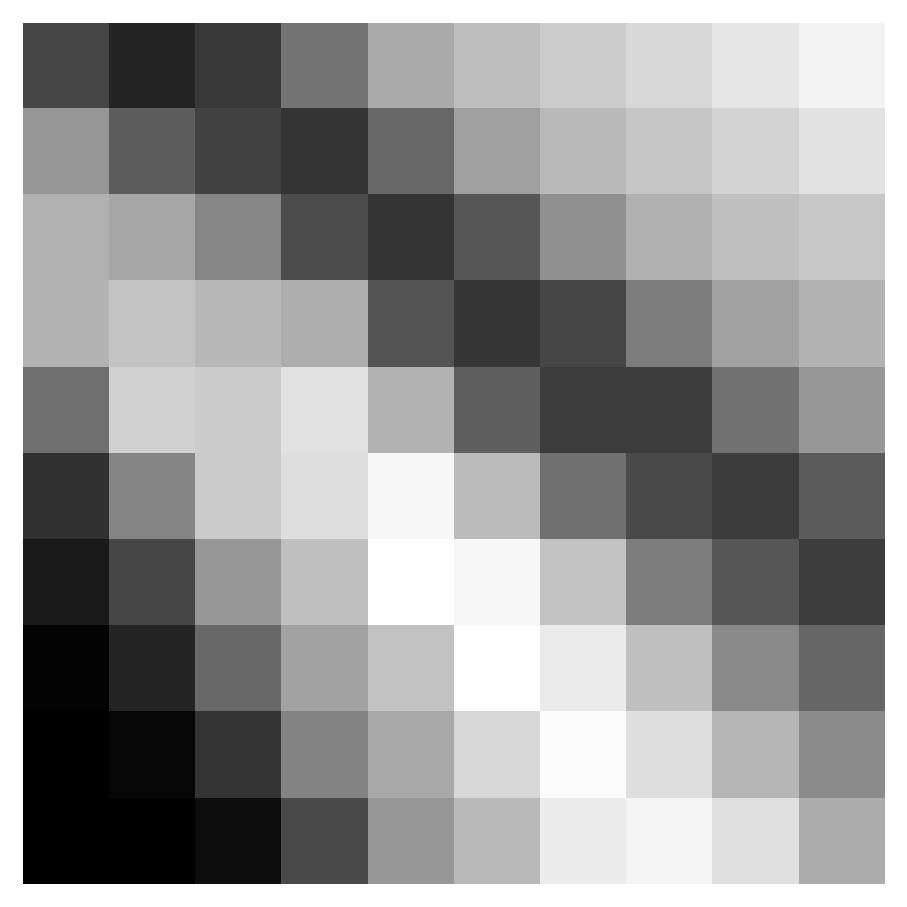

In [7]:
refImages = None
refNoises = None

def showMe() :
    global refImages, refNoises
    image = None
    while True:
        image = trainSet.__getitem__(34008,1620).squeeze()
        #image = trainSet[random.randint(0,len(trainSet)-1)].squeeze()
        if image.mean() > 0  and image.std() > 0.1 :
            break
        break
    tensorStat(image)
    image = image.to(TCfg.device)
    plotImage(image.cpu())
    refImages = torch.stack((image,image)).to(TCfg.device)
    refNoises = torch.randn((2,TCfg.latentDim)).to(TCfg.device)

showMe()


## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">etc</font>

In [8]:
def fillWheights(seq) :
    for wh in seq :
        if hasattr(wh, 'weight') :
            torch.nn.init.xavier_uniform_(wh.weight)

### <font style="color:lightblue">Generator</font>

In [9]:


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(TCfg.latentDim, DCfg.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + DCfg.sinoSh )
        )
        fillWheights(self.noise2latent)

        baseChannels = 64

        self.encode = nn.Sequential(

            nn.Conv2d(latentChannels+1, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

        )
        fillWheights(self.encode)


        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (baseChannels, 4, 4)),
        )
        fillWheights(self.link)


        self.decode = nn.Sequential(

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(baseChannels, baseChannels, (3,1)),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, 1, (1,3)),
            nn.Tanh()

        )
        fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = unsqeeze4dim(images)
        latent = self.noise2latent(noises)
        modelIn = torch.cat((images,latent),dim=1)
        mIn = modelIn[:,0,*DCfg.gapRng]
        mIn[()] = self.preProc(images[:,0,:,:])
        patches = self.body(modelIn) - 0.5
        mIn = mIn.unsqueeze(1)
        patches = mIn + torch.where( patches < 0 , patches * (mIn+0.5) , patches )
        return squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        res = torch.zeros(images[...,*DCfg.gapRng].shape, device=images.device)
        res[...,0] += 2*images[...,DCfg.gapRngX.start-1] + images[...,DCfg.gapRngX.stop]
        res[...,1] += 2*images[...,DCfg.gapRngX.stop] + images[...,DCfg.gapRngX.start-1]
        return res/3

    def generatePatches(self, images, noises=None) :
        if noises is None :
            noises = torch.randn(images.shape[0], TCfg.latentDim).to(TCfg.device)
        return self.forward((images,noises))


    def fillImages(self, images, noises=None) :
        images[...,*DCfg.gapRng] = self.generatePatches(images, noises)
        return images


    def generateImages(self, images, noises=None) :
        clone = images.clone()
        return self.fillImages(clone)



generator = Generator()
if True :
    generator = load_model(generator, model_path=f"model_{TCfg.exec}_gen.pt" )
else :
    try : os.remove(TCfg.historyHDF)
    except : pass
generator.to(TCfg.device)
model_summary = summary(generator, input_data=[ [refImages, refNoises] ] ).__str__()
print(model_summary)




/tmp/ipykernel_3726559/3525890942.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [2, 10, 2]                --
├─Sequential: 1-1                        [2, 7, 10, 10]            --
│    └─Linear: 2-1                       [2, 700]                  45,500
│    └─ReLU: 2-2                         [2, 700]                  --
│    └─Unflatten: 2-3                    [2, 7, 10, 10]            --
├─Sequential: 1-2                        [2, 1, 10, 2]             --
│    └─Sequential: 2-4                   [2, 64, 4, 4]             --
│    │    └─Conv2d: 3-1                  [2, 64, 8, 8]             4,672
│    │    └─LeakyReLU: 3-2               [2, 64, 8, 8]             --
│    │    └─Conv2d: 3-3                  [2, 64, 6, 6]             36,928
│    │    └─LeakyReLU: 3-4               [2, 64, 6, 6]             --
│    │    └─Conv2d: 3-5                  [2, 64, 4, 4]             36,928
│    │    └─LeakyReLU: 3-6               [2, 64, 4, 4]             --


### <font style="color:lightblue">Discriminator</font>

In [10]:

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        baseChannels = 64

        self.body = nn.Sequential(

            nn.Conv2d(1, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

            nn.Conv2d(baseChannels, baseChannels, 3),
            nn.LeakyReLU(0.2),

        )
        fillWheights(self.body)

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, 128),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        fillWheights(self.head)


    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        convRes = self.body(images)
        res = self.head(convRes)
        return res

discriminator = Discriminator()
discriminator = load_model(discriminator, model_path=f"model_{TCfg.exec}_dis.pt")
discriminator.to(TCfg.device)
model_summary = summary(discriminator, input_data=refImages ).__str__()
print(model_summary)




Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [2, 1]                    --
├─Sequential: 1-1                        [2, 64, 4, 4]             --
│    └─Conv2d: 2-1                       [2, 64, 8, 8]             640
│    └─LeakyReLU: 2-2                    [2, 64, 8, 8]             --
│    └─Conv2d: 2-3                       [2, 64, 6, 6]             36,928
│    └─LeakyReLU: 2-4                    [2, 64, 6, 6]             --
│    └─Conv2d: 2-5                       [2, 64, 4, 4]             36,928
│    └─LeakyReLU: 2-6                    [2, 64, 4, 4]             --
├─Sequential: 1-2                        [2, 1]                    --
│    └─Flatten: 2-7                      [2, 1024]                 --
│    └─Dropout: 2-8                      [2, 1024]                 --
│    └─Linear: 2-9                       [2, 128]                  131,200
│    └─Linear: 2-10                      [2, 1]                    129


/tmp/ipykernel_3726559/3525890942.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### <font style="color:lightblue">Test</font>

[0.4244197 0.4221485]
0.0014207506319507957 0.039805907756090164 28.017518997192383 -0.048343025147914886 0.06465709209442139


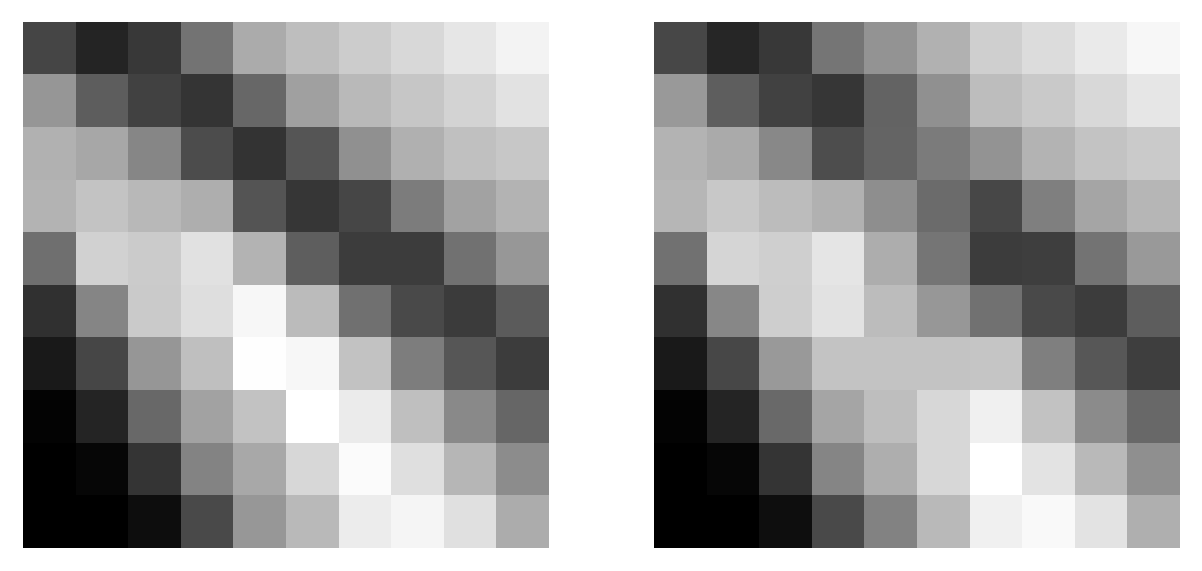

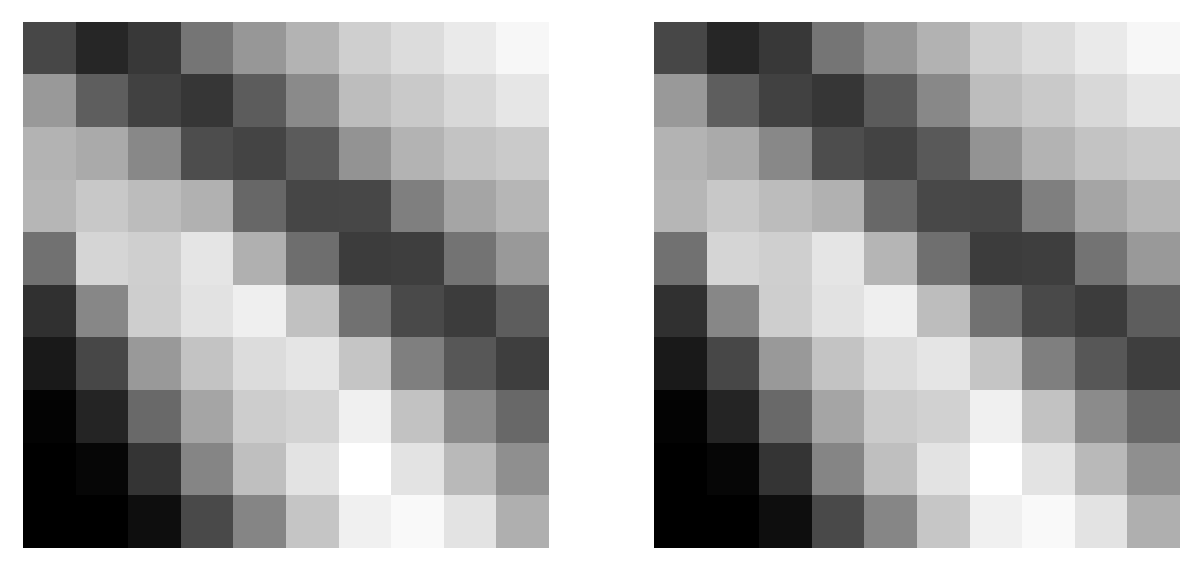

In [11]:
generator.eval()
discriminator.eval()
refImages[1,...,DCfg.gapRngX] = generator.preProc(refImages[1,...])
mgens = generator.generateImages(refImages,refNoises)
liks = discriminator(mgens)
print(liks.detach().cpu().squeeze().numpy())
tensorStat( mgens[1,*DCfg.disRng] - refImages[1,*DCfg.disRng] )
plotImages((refImages[0,...].detach().cpu().squeeze(),
            refImages[1,...].detach().cpu().squeeze()))
plotImages((mgens[0,...].detach().cpu().squeeze(),
            mgens[1,...].detach().cpu().squeeze()))


## <font style="color:lightblue">Train</font>

### <font style="color:lightblue">Metrics</font>

In [12]:
BCE = nn.BCELoss(reduction='none')
MSE = nn.MSELoss(reduction='none')


def applyWeights(inp, weights):
    inp = inp.squeeze()
    sum = len(inp)
    if not weights is None :
        inp *= weights
        sum = weights.sum()
    return inp.sum()/sum

def loss_Adv(y_true, y_pred, weights=None):
    loss = BCE(y_pred, y_true)
    return applyWeights(loss,weights)

def loss_Gen(y_true, y_pred, p_true, p_pred, weights=None):
    lossAdv = loss_Adv(y_true, y_pred, weights)
    lossesDif = MSE(p_pred, p_true).mean(dim=(1,2)) / (0.5+p_true.mean(dim=(1,2)))
    lossDif = applyWeights(lossesDif, weights)
    return lossAdv + 2000 * lossDif, lossAdv



### <font style="color:lightblue">Optimizers</font>

In [13]:

optimizer_G = optim.Adam(
    generator.parameters(),
    lr=TCfg.learningRateG,
    betas=(0.5, 0.999)
)
optimizer_D = optim.Adam(
    discriminator.parameters(),
    lr=TCfg.learningRateD,
    betas=(0.5, 0.999)
)


### <font style="color:lightblue">Train step</font>

In [14]:

torch.autograd.set_detect_anomaly(True)


class TrainInfo:
    bestRealImage = None
    bestRealPrediction = 0
    bestRealWght = 0
    worstRealImage = None
    worstRealPrediction = 0
    worstRealWght = 0
    bestFakeImage = None
    bestFakePrediction = 0
    bestFakeWght = 0
    worstFakeImage = None
    worstFakePrediction = 0
    worstFakeWght = 0
    ratReal = 0.0
    ratFake = 0.0
    totalImages = 0
    iterations = 0
    disPerformed = 0
    genPerformed = 0
    gaLoss = None


trainDis = True
trainGen = True
def train_step(images):
    global trainDis, trainGen
    TrainInfo.iterations += 1

    discriminator.eval()
    generator.eval()

    nofIm = images.shape[0]
    images = images.squeeze(1).to(TCfg.device)
    means = images.mean(dim=(1,2)).squeeze() + 0.5
    #stdds = images.std(dim=(1,2)).squeeze()
    absWeights = means + 1
    absWeights /= absWeights.sum()
    weights = absWeights.to(TCfg.device)
    #disWeights = stdds / means
    #disWeights /= disWeights.sum()
    #weights = absWeights + disWeights
    #weights /= weights.sum()

    fakeImages = generator.generateImages(images)
    y_pred_real = None
    y_pred_fake = None
    ratReal = 0
    ratFake = 0

    generator.eval()
    discriminator.train()
    counter = 0
    while trainDis:
        counter += 1
        TrainInfo.disPerformed += 1
        optimizer_D.zero_grad()
        y_pred_real = discriminator(images)
        y_pred_fake = discriminator(fakeImages)
        y_pred_both = torch.cat((y_pred_real, y_pred_fake), dim=0)
        labels = torch.cat( (
            torch.full((nofIm, 1),  TCfg.labelSmoothFac),
            torch.zeros(nofIm, 1) ),
            dim=0
        ).to(TCfg.device)
        D_loss = loss_Adv(labels, y_pred_both, torch.cat( (weights, weights) ) )
        D_loss.backward()
        optimizer_D.step()
        ratReal = torch.count_nonzero(y_pred_real > 0.5)/nofIm
        ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
        if ratReal > ratFake:
            trainGen = True
            break
        elif counter > 1:
            trainGen = ratFake < 0.1 or ratReal > 0.6
            break
        else:
            images = images.detach()
            fakeImages = fakeImages.detach()
    if not trainDis :
        with torch.no_grad():
            y_pred_real = discriminator(images)
            labels = torch.full((nofIm, 1),  TCfg.labelSmoothFac,
                                dtype=torch.float, device=TCfg.device)
            D_loss = loss_Adv(labels, y_pred_real, weights)
            ratReal = torch.count_nonzero(y_pred_real > 0.5)/nofIm


    discriminator.eval()
    generator.train()
    counter = 0
    while trainGen :
        counter += 1
        TrainInfo.genPerformed += 1
        optimizer_G.zero_grad()
        fakeImages = generator.generateImages(images)
        y_pred_fake = discriminator(fakeImages)
        labels = torch.ones(nofIm, 1).to(TCfg.device)
        G_loss, GA_loss = loss_Gen(labels, y_pred_fake,
                                   images[...,DCfg.gapRngX], fakeImages[...,DCfg.gapRngX],
                                   weights)
        G_loss.backward()
        optimizer_G.step()
        ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm
        if ratFake > 0.1 :
            trainDis = True
            break
        elif counter > 1:
            trainDis = ratReal < 0.1 or ratFake > 0.6
            break
        else :
            images = images.detach()
            fakeImages = fakeImages.detach()
    if not trainGen :
        with torch.no_grad():
            labels = torch.ones(nofIm, 1, dtype=torch.float, device=TCfg.device)
            G_loss, GA_loss = loss_Gen(labels, y_pred_fake,
                                       images[...,DCfg.gapRngX], fakeImages[...,DCfg.gapRngX],
                                       weights)
            ratFake = torch.count_nonzero(y_pred_fake > 0.5)/nofIm

    trainDis = trainGen = True


    idx = y_pred_real.argmax()
    TrainInfo.bestRealImage = images[idx,...]
    TrainInfo.bestRealPrediction = y_pred_real[idx].item()
    TrainInfo.bestRealWght = nofIm*weights[idx]
    idx = y_pred_real.argmin()
    TrainInfo.worstRealImage = images[idx,...]
    TrainInfo.worstRealPrediction =  y_pred_real[idx].item()
    TrainInfo.worstRealWght = nofIm*weights[idx]
    idx = y_pred_fake.argmax()
    TrainInfo.bestFakeImage = fakeImages[idx,...]
    TrainInfo.bestFakePrediction = y_pred_fake[idx].item()
    TrainInfo.bestFakeWght = nofIm*weights[idx]
    idx = y_pred_fake.argmin()
    TrainInfo.worstFakeImage = fakeImages[idx,...]
    TrainInfo.worstFakePrediction = y_pred_fake[idx].item()
    TrainInfo.worstFakeWght = nofIm*weights[idx]
    TrainInfo.ratReal += ratReal * nofIm
    TrainInfo.ratFake += ratFake * nofIm
    TrainInfo.totalImages += nofIm
    TrainInfo.gaLoss = GA_loss

    return D_loss, G_loss




### <font style="color:lightblue">Trainer</font>

In [18]:


G_LOSS = []
D_LOSS = []

def train(dataloader):

    discriminator.to(TCfg.device)
    generator.to(TCfg.device)
    refImages.to(TCfg.device)
    refNoises.to(TCfg.device)
    lastUpdateTime = time.time()

    epoch = 0
    while True:
        epoch += 1

        generator.train()
        discriminator.train()
        start = time.time()
        D_loss_list, G_loss_list = [], []

        for it , images in tqdm.tqdm(enumerate(dataloader), total=int(len(dataloader))):
            images = images.to(TCfg.device)
            D_loss, G_loss = train_step(images)
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)

            #if not it or it > len(dataloader)-2 or time.time() - lastUpdateTime > 60 :
            if time.time() - lastUpdateTime > 60 :
                lastUpdateTime = time.time()
                IPython.display.clear_output(wait=True)
                print(f"Epoch: {epoch}."
                      f" Dis loss: {D_loss:.3f} "
                      f"({TrainInfo.ratReal/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.disPerformed/TrainInfo.iterations:.3f}), "
                      f" Gen loss: {G_loss:.3f} "
                      f"({TrainInfo.ratFake/TrainInfo.totalImages:.3f} / "
                      f"{TrainInfo.genPerformed/TrainInfo.iterations:.3f}) "
                      f" GA loss: {TrainInfo.gaLoss:.3f}"
                      )

                TrainInfo.iterations = 0
                TrainInfo.totalImages = 0
                TrainInfo.ratReal = 0
                TrainInfo.ratFake = 0
                TrainInfo.genPerformed = 0
                TrainInfo.disPerformed = 0
                fourImages = np.ones( (2*DCfg.sinoSh[1] + DCfg.gapW ,
                                       4*DCfg.sinoSh[0] + 3*DCfg.gapW), dtype=np.float32  )
                def addImage(clmn, row, img) :
                    fourImages[ row * ( DCfg.sinoSh[1]+DCfg.gapW) : (row+1) * DCfg.sinoSh[1] + row*DCfg.gapW ,
                                clmn * ( DCfg.sinoSh[0]+DCfg.gapW) : (clmn+1) * DCfg.sinoSh[0] + clmn*DCfg.gapW ] = \
                        img.squeeze().detach().cpu().numpy()
                refNoises[0,:] = torch.randn(TCfg.latentDim)
                gens = generator.generateImages(refImages,refNoises)
                dif = gens[0,...] - refImages[1,...]
                tensorStat(dif[DCfg.disRng])
                hGap = DCfg.gapW // 2
                dif[:,hGap:hGap+DCfg.gapW] = (refImages[0,*DCfg.gapRng] - refImages[1,*DCfg.gapRng])
                dif[:,-DCfg.gapW-hGap:-hGap] = (gens[0,*DCfg.gapRng] - refImages[0,*DCfg.gapRng])
                if ( cof := max(-dif.min(),dif.max()) ) != 0 :
                    dif /= 2*cof
                disIn = torch.cat(( gens[0,...].unsqueeze(0), refImages), dim=0)
                liks = discriminator(disIn)
                addImage(0,0,TrainInfo.bestRealImage)
                addImage(0,1,TrainInfo.worstRealImage)
                addImage(1,0,TrainInfo.bestFakeImage)
                addImage(1,1,TrainInfo.worstFakeImage)
                addImage(2,0,gens[0,...])
                addImage(2,1,refImages[0,...])
                addImage(3,0,refImages[1,...])
                addImage(3,1,dif)

                print (f"TT: {TrainInfo.bestRealPrediction:.4e} ({TrainInfo.bestRealWght:.3f}),  "
                       f"FT: {TrainInfo.bestFakePrediction:.4e} ({TrainInfo.bestFakeWght:.3f}),  "
                       f"GI: {liks[0].item():.5f}, {liks[2].item():.5f} " )
                print (f"TF: {TrainInfo.worstRealPrediction:.4e} ({TrainInfo.worstRealWght:.3f}),  "
                       f"FF: {TrainInfo.worstFakePrediction:.4e} ({TrainInfo.worstFakeWght:.3f}),  "
                       f"RP: {liks[1].item():.5f}" )
                try :
                    #tifffile.imwrite(f"tmp_{TCfg.exec}.tif", fourImages)
                    addToHDF(TCfg.historyHDF, "data", fourImages)
                except :
                    eprint("Failed to save.")
                plt.imshow(fourImages, cmap='gray')
                plt.axis("off")
                plt.show()

        epoch_D_loss = sum(D_loss_list)/len(D_loss_list)
        epoch_G_loss = sum(G_loss_list)/len(G_loss_list)
        D_LOSS.append(epoch_D_loss.detach().cpu())
        G_LOSS.append(epoch_G_loss.detach().cpu())
        print('\n')
        print(f"Time for epoch {epoch + 1} is {time.time()-start} sec")
        print(f"Discriminator loss: {epoch_D_loss:.3f}, Generator loss: {epoch_G_loss:.3f}.")
        print('\n')
        save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")
        save_model(discriminator, TCfg.device, model_path=f"model_{TCfg.exec}_dis.pt")


## <font style="color:lightblue">Execute</font>

Epoch: 247. Dis loss: 0.673 (0.519 / 1.045),  Gen loss: 1.210 (0.282 / 1.045)  GA loss: 0.728
0.010103954933583736 0.06327229738235474 6.262131690979004 -0.07819823175668716 0.08348363637924194
TT: 1.0000e+00 (1.039),  FT: 9.9165e-01 (1.030),  GI: 0.57467, 0.18057 
TF: 8.5995e-03 (0.974),  FF: 1.8193e-02 (0.974),  RP: 0.73958


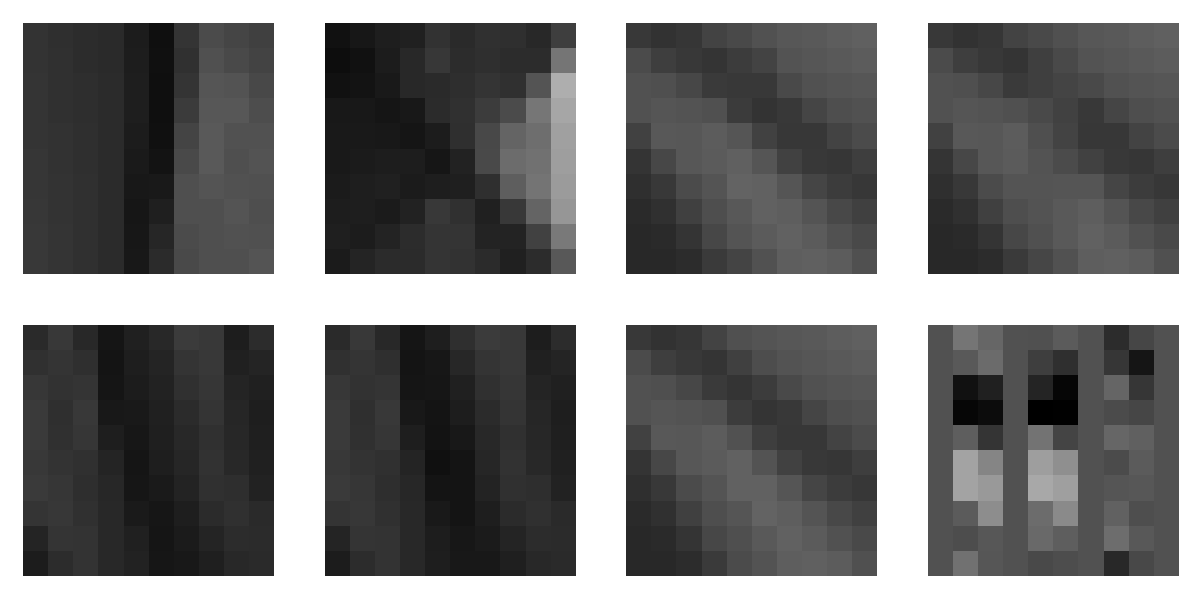

100%|██████████| 24/24 [00:57<00:00,  2.41s/it]



Time for epoch 248 is 63.32173538208008 sec
Discriminator loss: 0.672, Generator loss: 1.219.





  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
trainLoader = torch.utils.data.DataLoader(
    dataset=trainSet,
    batch_size=TCfg.batchSize,
    shuffle=True,
    num_workers=os.cpu_count()
)

trainGen=True
trainDis=True
#fillWheights(generator.body)
#fillWheights(discriminator.body)
#fillWheights(discriminator.head)
train(trainLoader)

## <font style="color:lightblue">Post</font>

In [ ]:
randIdx = random.randint(0,len(testSet)-1)
image = testSet[randIdx]
plt.imshow(image.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

#image = image.to(TCfg.device)
#fake_image = generate_images(image)
#plt.imshow(fake_image.detach().squeeze(), cmap='gray')
#plt.axis("off")
#plt.show()

addToHDF(f"test_{TCfg.exec}.hdf", "data", image)


In [ ]:
save_model(generator, TCfg.device, model_path=f"model_{TCfg.exec}_gen.pt")
save_model(discriminator, TCfg.device, model_path=f"model_{TCfg.exec}_dis.pt")
#save_model(generator, TCfg.device, model_path="saves/work_1.GEN.pt")
#save_model(discriminator, TCfg.device, model_path="saves/work_1.DIS.pt")